In [46]:
import time 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from Bio import Entrez
from bs4 import BeautifulSoup
Entrez.email = 'savandara.besse@gmail.com' #Use your own email

In [47]:
tqdm.pandas()

## Get tissue and stages from Biosample

In [3]:
def tidy_rows(original_tsa_metadata_before_cleaning, tsa_id):
    metadatas = []
    custom_columns = ['tsa_id', 'tax_id', 'species', 'family_id', 'family_name', 'order_id', 'order_name', 'bioproject']
    TMP = original_tsa_metadata_before_cleaning[original_tsa_metadata_before_cleaning['tsa_id'] == tsa_id ].reset_index(drop=True)
    tsa_tag = tsa_id[:4]
    TMP['biosample'] = TMP['biosample'].astype(str)
    for sample_list in TMP['biosample']:
        if sample_list != 'nan' :
            sample_list = sample_list.split(',')
            for sample in sample_list:
                metadata = list(TMP[custom_columns].values[0])
                metadata.append(sample)
                metadata.append(tsa_tag)
                metadatas.append(metadata)
        else :
            sample = 'na'
            metadata = list(TMP[custom_columns].values[0])
            metadata.append(sample)
            metadata.append(tsa_tag)
            metadatas.append(metadata)

    return metadatas

def tidy_table(original_tsa_metadata_before_cleaning):
    custom_columns = ['tsa_id', 'tax_id', 'species', 'family_id', 'family_name', 'order_id', 'order_name', 'bioproject','biosample', 'TSA']
    tsa_rows = [ pd.DataFrame(tidy_rows(original_tsa_metadata_before_cleaning, tsa_id), columns=custom_columns) for tsa_id in tqdm(original_tsa_metadata_before_cleaning['tsa_id'].values) ] 
    return pd.concat(tsa_rows).reset_index(drop=True)

def collect_infos(tidy_table, sample, table_type):
    if 'v1' in table_type :
         custom_columns = ['TSA', 'tsa_id', 'bioproject', 'biosample']
    elif 'v2' in table_type:
        custom_columns = ['TSA', 'tsa_id', 'tax_id', 'species', 'family_id', 'family_name', 'order_id', 'order_name', 'bioproject','biosample']
    TMP = tidy_table[tidy_table['biosample'] == sample ][custom_columns]
    metadata = list(TMP[custom_columns].values[0])

    bio_handle = Entrez.esearch(db="biosample", term=sample)
    record = Entrez.read(bio_handle)['IdList']
    handle = Entrez.esummary(db="biosample", id=record[0])
    summary = Entrez.read(handle)['DocumentSummarySet']['DocumentSummary']
    for tag in summary :
        soup = BeautifulSoup(tag['SampleData'], 'lxml')
        attributes = soup.find_all('attribute')
        keywords = []
        for elem in attributes :
            for child in elem.children :
                if elem['attribute_name'] == 'tissue':
                    keywords.append(child.lower())
                if elem['attribute_name'] == 'tissue_type':
                    keywords.append(child.lower())
                if elem['attribute_name'] == 'sample-type':
                    keywords.append(child.lower())
                if elem['attribute_name'] == 'sex' :
                    keywords.append(child.lower())
                if elem['attribute_name'] == 'dev_stage' :
                    keywords.append(child.lower())
        metadata.append(keywords)
    return metadata

In [4]:
original_tsa_metadata_before_cleaning = pd.read_csv('../Data/01_Oskar_identification/2019/transcriptome_insect_database.csv')
tsa_tidy_table_v2 = tidy_table(original_tsa_metadata_before_cleaning)

100%|██████████| 1164/1164 [00:03<00:00, 301.34it/s]


In [5]:
tsa_tidy_table_v2[tsa_tidy_table_v2['biosample'] == 'na'].reset_index(drop=True).to_csv('../Data/02_Oskar_analyses/2.12/tsa_metadata_tidy_table_nobiosample.csv', index=False)
tsa_tidy_table_v2[tsa_tidy_table_v2['biosample'] != 'na'].reset_index(drop=True).to_csv('../Data/02_Oskar_analyses/2.12/tsa_metadata_tidy_table_allbiosample.csv', index=False)

In [6]:
tsa_tidy_table_v2 = pd.read_csv('../Data/02_Oskar_analyses/2.12/tsa_metadata_tidy_table_allbiosample.csv')

In [7]:
%%time
results = []
for sample in tqdm(tsa_tidy_table_v2['biosample'].values) :
    time.sleep(0.001)
    results.append(collect_infos(tsa_tidy_table_v2, sample, 'v2'))

100%|██████████| 2339/2339 [39:22<00:00,  1.01s/it]

CPU times: user 1min 37s, sys: 8.49 s, total: 1min 45s
Wall time: 39min 22s


In [8]:
tsa_raw_metadata = pd.DataFrame(results, columns=['TSA', 'tsa_id', 'tax_id', 'species', 'family_id', 'family_name', 'order_id', 'order_name', 'bioproject','biosample', 'keywords'])

In [9]:
tsa_raw_metadata = tsa_raw_metadata[tsa_raw_metadata['biosample'] != 'na'].reset_index(drop=True)

In [10]:
tsa_raw_metadata.to_csv('../Data/02_Oskar_analyses/2.12/insect_metadata_biosample_database.csv', index=False, na_rep='None')

## Categorize metadata

In [11]:
tissue_mapping = {
    'None':'None',
    'whole insects':'whole organism',
    'regurgitant':'None',
    'central nervous system':'brain',
    'abdominal fat body':'fat body',
    'female thorax':'thorax',
    'male thorax':'thorax',
    'male other accessory glands':'accessory glands',
    'female spermatophore digesting gland / bursa':'bursa',
    'male spiral gland':'spiral gland',
    'female spermatheca':'spermatheca',
    'whole organism':'whole organism',
    'head, thorax, forelegs':' & '.join(['head', 'thorax', 'forelegs']),
    'silk glands':'silk glands',
    'whole fly':'whole organism',
    'light organ':'light organ',
    'whole larva excluding light organ':'whole organism',
    'midgut':'midgut',
    'malpighian tubules':'malpighian tubules',
    'fat body':'fat body',
    'testicle pair':'testes',
    'ovary':'ovaries',
    'head and thorax':' & '.join(['head','thorax']),
    'whole body':'whole organism',
    'missing':'undetermined tissue',
    'abdomen':'abdomen',
    'entire organism':'whole organism',
    'bursa':'bursa',
    'bursal gland':'bursa',
    'thorax':'thorax',
    'whole animal':'whole organism',
    'fat body, reproductive tissues':' & '.join(['fat body', 'reproductive tissues']),
    'brain':'brain',
    'testis':'testes',
    'various':'undetermined tissue',
    'antennae, legs and larvae':' & '.join(['antennae', 'legs','larvae']),
    'head':'head',
    'antennae':'antennae',
    'heads':'head',
    'venom apparatus':'venom apparatus',
    'body without venom gland':'whole organism',
    'whole larvae':'whole organism',
    'entire body':'whole organism',
    'flight muscle':'muscle',
    'whole heads':'head',
    'males without ovaries or head':'whole organism',
    'females without ovaries or head':'whole organism',
    'muscle (abdominal)':'muscle',
    'testes':'testes',
    'ovaries':'ovaries',
    'fatbody':'fat body',
    'brain/head':'brain',
    'brain (heads with antennae)':' & '.join(['head','antennae']),
    'egg / embryo':'egg',
    'whole larva':'whole organism',
    'brain (heads)':'brain',
    'muscle (from abdomen)':'muscle',
    'salivary glands':'salivary glands',
    'not applicable':'undetermined tissue',
    'salivary gland':'salivary glands',
    'midgut head':'midgut',  
    'whole individual':'whole organism',
    'ovarian':'ovaries',
    'whole insect':'whole organism',
    'hemocytes':'blood', 
    'mouthpart':'mouthpart',
    'tarsus':'tarsus',
    'pupal head':'head',
    'antenna':'antennae',
    'venom gland and venom sac':' & '.join(['venom gland','venom sac']),
    'whole larvae body':'whole organism',
    'pheromone gland':'pheromone gland',    
    'prothoracic gland':'prothoracic gland', 
    'whole':'whole organism',
    'anterior midgut':'midgut',
    'cns':'brain',
    'foregut':'foregut',
    'whole midge':'whole organism', 
    'head+thorax':' & '.join(['head','thorax']),
    'entire thorax':'thorax',
    'body':'whole organism', 
    'hemocyte':'blood',
    'neuron':'brain', 
    'the fat body and the ovary':' & '.join(['fat body', 'ovaries']),
    'wing of the nymph':'wing',
    '-':'undetermined tissue',
    'italy':'undetermined tissue',   
    'venom gland':'venom gland',
    'adult':'whole organism',
    'bacteriome':'undetermined tissue',
    'whole body (minus bacteriome)':'whole organism', 
    'whole female adults, venom glands and female body carcasses':'whole organism',
    'midgut unfed':'midgut',
    'blood fed midgut':'midgut',
    'full':'whole organism',
    'maxillary palps':'maxillary palps',
    'male heads':'head',
    'egg':'egg',
    'laves_stage_3-4':'whole organism',
    'larval':'whole organism',
    'larva':'whole organism',
    'pupae':'whole organism',
    'egg0-24h':'egg',
    'reproductive tract': 'reproductive organs',
    'reproductive organs':'reproductive organs',
    'multi':'undetermined tissue',
    'adult female antennae':'antennae',
    'adult male antennae':'antennae',
    'adult whole females':'whole organism',
    'adult whole males':'whole organism',
    'single whole larva':'whole organism',
    'pooled whole organism':'whole organism',
    'brains':'brain',
    'proboscises':'proboscises',
    'rostrums':'rostrums',
    'abdominal tips':'abdominal tips',
    'hindlegs':'hindlegs',
    'midlegs':'midlegs',
    'forelegs':'forelegs',
    'whole gut':'gut',
    'gut, fat body, malpighian tubules, glands':' & '.join(['gut', 'fat body', 'malpighian tubules', 'glands']),
    'posterior abdomen':'abdomen',
    'eggs, larvae, pupae and adults':'whole organism',
    'integument':'integument',
    'bacteriocyte':'undetermined tissue',
    'whole adult insect':'whole organism',
    'legs':'legs',
    'wing disc':'wing',
    'gut':'gut',
    'adults, nymphs, guts':'gut',
    'head and 6 legs': 'head',
    'head and forelegs': 'head',
    '1 leg':'leg',
    '3 legs':'leg',
    "head and prothorax": "head & prothorax",
    "larval head": "head",
    "whole body tisue": "whole organism",
    "large globular cells": "large globular cells",
    "body carcass without embryos": "whole organism",
    "whole body without gut": "whole organism",
    "whole body tissue": "whole organism",
    "mid-gut": "midgut",
    "head and abdomen": "head & abdomen",
    "whole cricket": "whole organism",
    "prothorax": "prothorax",
    "the whole body after head, wings and gut were removed": "whole organism",
    "egg & larvae": "egg & larvae",
    "head horn": "head",
    "thorax horn": "thorax",
    "whole adult": "whole organism",
    "whole insect tissue": "whole organism",
    "head/legs/thorax": "head & legs & thorax",
    "entire individual": "whole organism",
    "leg": "leg",
    "whole individual preps": "whole organism",
    "thoracic gland": "thoracic gland",
    "adult body": "whole organism",
    "entire insect": "whole organism",
    "central nervous system (cns)": "brain",
    "throax,head": "head & thorax",
    "neuronal, prothoracic ganglion": "brain",
    "ehad": "brain",
    "tisue (mostly muscle)": "muscle",
    "mixed": "whole organism",
    "whole bodies": "whole organism",
    "adult thorax": "thorax",
    "tisuue (mostly muscle)": "muscle",
    "accessory gland": "accessory gland",
    "carcass": "whole organism",
    "whole eggs": "egg",
    "embryonic foreleg": "foreleg",
    "embryonic midleg": "midleg",
    "embryonic hindleg": "hindleg",
    "venom gland and venom reservoir": "venom gland",
    "wing, eyespot in m3 wing sector": "wing",
    "wing, eyespot in cu1 wing sector": "wing"
}

stage_mapping = {
    '1st instar larva (1d post molt)':'1st instar larvae',
    '2nd instar heads (1day post-molt)':'2nd instar larvae',
    '2nd instar larva (1d post molt)':'2nd instar larvae', 
    '2nd instar larvae':'2nd instar larvae',
    '3nd instar larva (1d post molt)':'3rd instar larvae',
    '3rd instar heads (1day post-molt)':'3rd instar larvae', 
    '3rd/4th instar nymphs':' & '.join(['3rd instar larvae','4th instar larvae']),
    '4th _ early instar heads (molt within 12h)':'4th instar larvae',
    '4th _ late instar heads (when head capsule slipped)':'4th instar larvae', 
    '5th instar':'5th instar larvae',
    '5th instar larvae':'5th instar larvae', 
    '5th instar nymph':'5th instar nymph', 
    'None':'None', 
    'adult':'adult',
    'adult - early (1 day post eclosion)':'adult',
    'adult - early (1-3 days post eclosion)':'adult',
    'adult - early - (1 day post eclosion) - ovaries':'adult',
    'adult - early - (1-3 days post eclosion) - testes':'adult',
    'adult - early- mid age (3-5 days post eclosion)':'adult',
    'adult - mid age (7-9 days post eclosion)':'adult',
    'adult - middle age (3 days post eclosion)':'adult',
    'adult - middle age (7 days post eclosion)':'adult', 
    'adult female':'adult',
    'adult male':'adult', 
    'adult nurse':'adult', 
    'adults':'adult',
    'adults and fifth instar nymphs':' & '.join(['adult','5th instar nymph']), 
    'adults and third instar larvae':' & '.join(['adult','3rd instar larvae']),
    'all':'all stages', 
    'all development stages':'all stages', 
    'crawlers':'larvae',
    'crawlers after settlement':'larvae', 
    'early egg (laid within 3h)':'egg', 
    'egg':'egg',
    'egg to adult':'all stages', 
    'eggs, larva 1 to 5 and adusts':'all stages',
    'eggs, larvae, pupae, and adults':'all stages', 
    'fifth instar':'5th instar larvae',
    'fourth instar larvae':'4th instar larvae', 
    'imago':'imago',
    'juvenil':'juvenil', 
    'l3 l4':' & '.join(['3rd instar larvae','4th instar larvae']),
    'l5 larvae, pupae and adults':'all stages', 
    'larva':'larvae', 
    'larvae':'larvae',
    'larvae; pupae; adults':'all stages', 
    'larval':'larvae', 
    'larval (neonate)':'larvae',
    'larval - 3rd instar late (when head capsule slipped)':'4th instar larvae',
    'larval - 4th instar - late (post head capsule slippage)':'4th instar larvae',
    'larval - 4th instar early (molt within 12h)':'4th instar larvae',
    'larval - 4th instar late (when head capsule slipped)':'4th instar larvae',
    'larval - 5th instar (wandering stage)':'5th instar larvae',
    'larval - 5th instar - early (1 day post-molt)':'5th instar larvae',
    'larval - 5th instar (wandering stage)':'5th instar larvae',
    'larval - 5th instar - (wandering stage)':'5th instar larvae',
    'larval - 5th instar - early (within 12 h post-molt)':'5th instar larvae',
    'larval - 5th instar - late (pre-wandering)':'5th instar larvae',
    'larval - 5th instar early (1-3 h post molt)':'5th instar larvae',
    'larval - 5th instar early (24h post molt)':'5th instar larvae',
    'larval - 5th instar early (molt within 12h)':'5th instar larvae',
    'larval - 5th instar late (before wandering)':'5th instar larvae',
    'larval - 5th instar late (pre-wandering)':'5th instar larvae',
    'larval - 5th instar wandering':'5th instar larvae',
    'larval - early 4th instar (immediately post molt) - oral - mock infected - (stress control)' : '4th instar larvae',
    'larval, pupal, adult':'all stages',
    'larval-5th - early instar heads (molted within 12h)':'5th instar larvae',
    'larval-5th - mid instar heads (2d after molting)':'5th instar larvae',
    'larval-5th - pre-wandering heads':'5th instar larvae', 
    'late egg (before hatch)':'egg',
    'missing':'undetermined stage', 
    'nymph':'nymph', 
    'nymphs':'nymph', 
    'nymphs and adults':' & '.join(['nymph','adult']), 
    'pupa':'pupae', 
    'pupae':'pupae',
    'pupal':'pupae', 
    'pupal - early (1 day post pupation)':'pupae',
    'pupal - early (1-3d old)':'pupae',
    'pupal - early (3 days post pupation)- testes':'pupae',
    'pupal - late (15-18 days post pupation)':'pupae',
    'pupal - late - (15-18 days post pupation)- testes':'pupae',
    'pupal - late - (15-18 days post pupation) - ovaries':'pupae',
    'pupal - pharate (before eclosion)':'pupae', 
    'soon after fertilization':'egg',
    'third-instars larvae of moths':'3rd instar larvae',
    '5th instar caterpillar, nd population, brassica diet': '5th instar larvae',
    "prepupa": "pupae",
    "1day pupa": "pupae",
    "juvenile": "adult",
    "developmental; pre-hatch": "",
    "lfi1": "larvae",
    "lfi2": "larvae",
    "lfi3": "larvae",
    "plfi1": "pupae",
    "plfi2": "pupae",
    "plfi3": "pupae",
    "tlfi1": "adult",
    "tlfi2": "adult",
    "tlfi3": "adult",
    "worker": "adult",
    "reproductive": "adult",
    "1st instar nymph": "nymph",
    "middle instar individual": "larvae",
    "embryo": "embryo",
    "adults and nymphs": "adult & nymph",
    "adult + juvenile pooled": "adult",
    "unknown": "None",
    "male": "None",
    "not collected": "None",
    "mixed individuals": "adult",
    "larvae of first instar stage": "larvae",
    "larvae of fifth instar stage": "larvae",
    "mixed": "adult",
    "4th instar larvae": "larvae",
    "white pupae": "pupae",
    "adults, pupae, first- to third-instar larvae and eggs": "adult & pupae & larvae & egg",
    "fourth instar": "larvae",
    "pharate pupa (prepupa)": "pupae",
    "old worker": "adult",
    "1st instar larva": "larvae",
    "fifth-instar first day": "larvae",
    "early pupa (3-6h after pupation)": "pupae",
    "": "None"
}

sex_mapping = {
    'missing':'undetermined sex',
    'None':'None',
    'not determined':'undetermined sex',
    'not collected':'undetermined sex',
    'pooled male and female':'pooled sex',
    'female':'female',
    'male':'male',
    'not applicable':'undetermined sex',
    'male and female':'pooled sex',
    'mixed':'pooled sex',
    'indeterminate at this stage':'undetermined sex',
    'mixed sex':'pooled sex', 
    'na':'undetermined sex', 
    '-':'undetermined sex', 
    'neuter':'neuter', 
    'mix':'pooled sex', 
    'hermaphrodite':'hermaphrodite',
    'male and femaile':'pooled sex', 
    'pooled males and females':'pooled sex', 
    'f':'female',
    'm':'male',
    'undetermined':'undetermined sex',
}

cleaned_stage_mapping = {
    'larvae': [0, 1, 0, 0, 0],
    'None': [0, 0, 0, 0, 0],
    'adult': [0, 0, 0, 0, 1],
    'all stages': [1, 1, 1, 1, 1],
    'juvenil': [0, 0, 0, 1, 0],
    '5th instar nymph': [0, 0, 0, 1, 0],
    '3rd instar larvae & 4th instar larvae': [0, 1, 0, 0, 0],
    '4th instar larvae': [0, 1, 0, 0, 0],
    '5th instar larvae': [0, 1, 0, 0, 0],
    'pupae': [0, 0, 1, 0, 0],
    '2nd instar larvae': [0, 1, 0, 0, 0],
    '3rd instar larvae': [0, 1, 0, 0, 0],
    'egg': [1, 0, 0, 0, 0],
    '1st instar larvae': [0, 1, 0, 0, 0],
    'nymph': [0, 0, 0, 1, 0],
    'adult & 3rd instar larvae': [0, 1, 0, 0, 1],
    'undetermined stage': [0, 0, 0, 0, 0],
    'embryo': [1, 0, 0, 0, 0],
    'adult & nymph': [0, 0, 0, 1, 1],
    'adult & pupae & larvae & egg': [1, 1, 1, 0, 1],
    'imago': [0, 0, 0, 0, 1],
    'nymph & adult': [0, 0, 0, 1, 1],
    'adult & 5th instar nymph': [0, 0, 0, 1, 1],
    '': [0, 0, 0, 0, 0]
}

def tissue_map(s):
    if s not in tissue_mapping.keys():
        if s not in done:
            print(s)
            done.append(s)
    else:
        return tissue_mapping[s]


def stage_map(s):
    s = s.replace('  ',' ')
    if s not in stage_mapping:
        if s not in done:
            print(s)
            done.append(s)
    else:
        return stage_mapping[s]


def sex_map(s):
    s = s.replace('  ',' ')
    if s not in sex_mapping:
        if s not in done:
            print(s)
            done.append(s)
    else:
        return sex_mapping[s]

    
def cleaned_stage_map(x, col):
    if x not in cleaned_stage_mapping:
        print(x)
    return cleaned_stage_mapping[x][col]


In [12]:
def get_raw_keyword(keywords, keyword_type):
    if 'tissue' in keyword_type:
        mapping_object = mapping_bgm['raw_tissue'].values
    if 'sex' in keyword_type:
        mapping_object = sex_mapping.keys()
    if 'stage' in keyword_type:
        mapping_object = stage_mapping.keys()

    if len(keywords) == 0:
        return None
    if len(keywords) > 1 :
        all_keywords = [ k for k_list in keywords for k in k_list.split(',') ]
        for k in all_keywords:
            if k in mapping_object:
                return k
    else:
        for k in keywords:
            if k in mapping_object:
                return k

In [17]:
mapping_bgm = pd.read_csv('../Data/02_Oskar_analyses/2.3/TableS3_germline_brain_table.csv')
mapping_bgm = mapping_bgm.fillna(0)
mapping_bgm['germline'] = mapping_bgm['germline'].astype(int)
mapping_bgm['brain'] = mapping_bgm['brain'].astype(int)

In [18]:
tsa_raw_metadata['raw_tissue'] = tsa_raw_metadata['keywords'].progress_apply(get_raw_keyword, args=('tissue',)).astype(str)
tsa_raw_metadata['raw_sex'] = tsa_raw_metadata['keywords'].progress_apply(get_raw_keyword, args=('sex',)).astype(str)
tsa_raw_metadata['raw_stage'] = tsa_raw_metadata['keywords'].progress_apply(get_raw_keyword, args=('stage',)).astype(str)

100%|██████████| 2339/2339 [00:00<00:00, 219164.87it/s]


In [19]:
done = []
tsa_raw_metadata['clean_tissue'] = tsa_raw_metadata['raw_tissue'].progress_apply(tissue_map).astype(str)
tsa_raw_metadata['clean_sex'] = tsa_raw_metadata['raw_sex'].progress_apply(sex_map).astype(str)
tsa_raw_metadata['clean_stage'] = tsa_raw_metadata['raw_stage'].progress_apply(stage_map).astype(str)

100%|██████████| 2339/2339 [00:00<00:00, 440801.45it/s]


In [20]:
tsa_raw_metadata = tsa_raw_metadata.merge(mapping_bgm, on='raw_tissue')

In [21]:
tsa_raw_metadata['egg'] = tsa_raw_metadata['clean_stage'].apply(cleaned_stage_map, args=(0,))
tsa_raw_metadata['larvae'] = tsa_raw_metadata['clean_stage'].apply(cleaned_stage_map, args=(1,))
tsa_raw_metadata['pupae'] = tsa_raw_metadata['clean_stage'].apply(cleaned_stage_map, args=(2,))
tsa_raw_metadata['juvenil'] = tsa_raw_metadata['clean_stage'].apply(cleaned_stage_map, args=(3,))
tsa_raw_metadata['adult'] = tsa_raw_metadata['clean_stage'].apply(cleaned_stage_map, args=(4,))

In [22]:
tsa_raw_metadata[tsa_raw_metadata['order_name'] == 'Coleoptera']

,TSA,tsa_id,tax_id,species,family_id,family_name,order_id,order_name,bioproject,biosample,...,clean_tissue,clean_sex,clean_stage,brain,germline,egg,larvae,pupae,juvenil,adult
31,GHRK,GHRK00000000.1,50390,Diabrotica virgifera virgifera,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA490283,SAMN10032278,...,whole organism,male,adult,0,0,0,0,0,0,1
32,GHRK,GHRK00000000.1,50390,Diabrotica virgifera virgifera,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA490283,SAMN10032279,...,whole organism,female,adult,0,0,0,0,0,0,1
33,GHRK,GHRK00000000.1,50390,Diabrotica virgifera virgifera,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA490283,SAMN10032280,...,whole organism,pooled sex,adult,0,0,0,0,0,0,1
34,GHRK,GHRK00000000.1,50390,Diabrotica virgifera virgifera,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA490283,SAMN10032302,...,whole organism,pooled sex,,0,0,0,0,0,0,0
35,GHRK,GHRK00000000.1,50390,Diabrotica virgifera virgifera,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA490283,SAMN10032278,...,whole organism,male,adult,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,GDAR,GDAR00000000.1,77166,Dendroctonus ponderosae,7042.0,Curculionidae,7041,Coleoptera,PRJNA269763,SAMN03257011,...,midgut,male,adult,0,0,0,0,0,0,1
2278,GDAR,GDAR00000000.1,77166,Dendroctonus ponderosae,7042.0,Curculionidae,7041,Coleoptera,PRJNA269763,SAMN03257012,...,midgut,male,adult,0,0,0,0,0,0,1
2294,GBUI,GBUI00000000.1,80249,Phaedon cochleariae,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA210148,SAMN02351150,...,whole organism,None,larvae,0,0,0,1,0,0,0
2295,GBUI,GBUI00000000.1,80249,Phaedon cochleariae,27439.0,Chrysomelidae,7041,Coleoptera,PRJNA210148,SAMN02351150,...,whole organism,None,larvae,0,0,0,1,0,0,0


In [23]:
tsa_raw_metadata.to_csv('../Data/02_Oskar_analyses/2.12/tissue_stage_binned.csv', index=False)

#### Finding Oskar

In [25]:
def oskar_found(x):
    if x > 0:
        return 'found'
    else:
        return 'not found'

In [26]:
search_results = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')
TSA_search_results = search_results[search_results['source'] == 'TSA'][['id', 'hits', 'source', 'filtered_hits']].rename(columns={'id': 'tsa_id'})
master_tsa_table = tsa_raw_metadata.merge(TSA_search_results, on='tsa_id')
master_tsa_table['oskar'] = master_tsa_table['filtered_hits'].apply(oskar_found)

In [27]:
master_tsa_table

,TSA,tsa_id,tax_id,species,family_id,family_name,order_id,order_name,bioproject,biosample,...,germline,egg,larvae,pupae,juvenil,adult,hits,source,filtered_hits,oskar
0,GDYR,GDYR00000000.1,1661803,Antongilia madagassa,55086.0,Bacillidae,7020,Phasmatodea,PRJNA286380,SAMN04005165,...,0,0,0,0,0,1,0,TSA,0.0,not found
1,GDZN,GDZN00000000.1,590986,Orestes mouhotii,262140.0,Heteropterygidae,7020,Phasmatodea,PRJNA286420,SAMN04005205,...,0,0,0,0,0,1,0,TSA,0.0,not found
2,GDCD,GDCD00000000.1,1603015,Diapherodes gigantea,55199.0,Phasmatidae,7020,Phasmatodea,PRJNA273031,SAMN03339334,...,0,0,0,0,1,0,0,TSA,0.0,not found
3,GDCE,GDCE00000000.1,614091,Agamemnon cornutus,58556.0,Pseudophasmatidae,7020,Phasmatodea,PRJNA273019,SAMN03339322,...,0,0,0,0,0,1,0,TSA,0.0,not found
4,GCPP,GCPP00000000.1,1603008,Orthomeria sp. AD-2014,262154.0,Aschiphasmatidae,7020,Phasmatodea,PRJNA273045,SAMN03339348,...,0,0,0,0,0,1,0,TSA,0.0,not found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,GAWM,GAWM00000000.1,179676,Culicoides sonorensis,41819.0,Ceratopogonidae,7147,Diptera,PRJNA238338,SAMN02646755,...,0,0,0,0,0,0,1,TSA,1.0,found
2220,GAWM,GAWM00000000.1,179676,Culicoides sonorensis,41819.0,Ceratopogonidae,7147,Diptera,PRJNA238338,SAMN02646756,...,0,0,0,0,0,0,1,TSA,1.0,found
2221,GAWM,GAWM00000000.1,179676,Culicoides sonorensis,41819.0,Ceratopogonidae,7147,Diptera,PRJNA238338,SAMN02646757,...,0,0,0,0,0,0,1,TSA,1.0,found
2222,GAWM,GAWM00000000.1,179676,Culicoides sonorensis,41819.0,Ceratopogonidae,7147,Diptera,PRJNA238338,SAMN02646758,...,0,0,0,0,0,0,1,TSA,1.0,found


In [28]:
master_tsa_table.to_csv('../Data/02_Oskar_analyses/2.12/tissue_stage_binned_with_oskar_results.csv', index=False)

### 1. Plots for developmental stages

In [30]:
np.unique(tsa_raw_metadata['clean_sex'])

array(['None', 'female', 'hermaphrodite', 'male', 'neuter', 'pooled sex',
       'undetermined sex'], dtype=object)

In [31]:
print("Percent of TSA dataset with sex metadata")
len(tsa_raw_metadata[~tsa_raw_metadata['clean_sex'].isin(["None", "undetermined sex"])]['tsa_id'].unique())/ len(TSA_search_results)

Percent of TSA dataset with sex metadata


0.3170080142475512

In [32]:
np.unique(tsa_raw_metadata['clean_stage'])

array(['', '3rd instar larvae', '3rd instar larvae & 4th instar larvae',
       '4th instar larvae', '5th instar larvae', '5th instar nymph',
       'None', 'adult', 'adult & 3rd instar larvae', 'adult & nymph',
       'all stages', 'egg', 'embryo', 'imago', 'juvenil', 'larvae',
       'nymph', 'nymph & adult', 'pupae', 'undetermined stage'],
      dtype=object)

In [33]:
print("Percent of TSA dataset with stage metadata")
len(tsa_raw_metadata[~tsa_raw_metadata['clean_stage'].isin(['',"None", "undetermined stage"])]['tsa_id'].unique()) / len(TSA_search_results)

Percent of TSA dataset with stage metadata


0.5253784505788067

In [34]:
mapping = {
   '1st instar larvae':'larvae', 
   '2nd instar larvae':'larvae', 
   '3rd instar larvae':'larvae',
   '3rd instar larvae & 4th instar larvae':'larvae', 
   '4th instar larvae':'larvae',
   '5th instar larvae':'larvae', 
    '5th instar nymph':'nymph',
    'adult & 3rd instar larvae':'undetermined stage',
}

def simplify_stages(x):
    if x in mapping:
        return mapping[x]
    else:
        return x
    
master_tsa_table['simple_stage'] = master_tsa_table['clean_stage'].apply(simplify_stages)

In [35]:
stage_df = master_tsa_table.groupby(['simple_stage', 'oskar'], as_index=False).count()[['simple_stage', 'oskar', 'species']]
stage_df = stage_df.rename(columns={'species':'counts'})
total_stage_df = master_tsa_table.groupby(['simple_stage'], as_index=False).count()[['simple_stage', 'species']]
tmp = stage_df.merge(total_stage_df, on='simple_stage')
stage_df['count_proportion'] = tmp['counts']/tmp['species'] * 100
total_stage_df['overal_proportion'] = total_stage_df['species']/total_stage_df['species'].sum() * 100

In [48]:
total_stage_df

,simple_stage,species,overal_proportion
0,None,822,36.960432
1,adult,1075,48.336331
2,adult & nymph,1,0.044964
3,all stages,6,0.269784
4,egg,5,0.224820
5,imago,1,0.044964
6,juvenil,5,0.224820
7,larvae,98,4.406475
8,nymph,18,0.809353
9,nymph & adult,1,0.044964


In [50]:
sns.set()

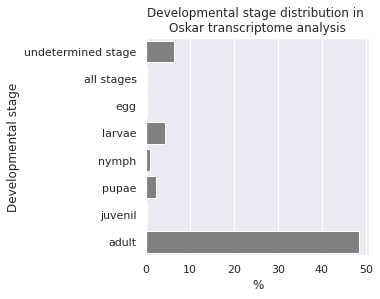

In [51]:
stage_order = ['undetermined stage',
               'all stages', 
               'egg', 
               'larvae', 
               'nymph', 
               'pupae', 
               'juvenil',
               'adult',
               ]

fig = plt.figure(figsize=(4,4))
sns.barplot(data=total_stage_df, x='overal_proportion', y='simple_stage', order=stage_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Developmental stage')
plt.title('Developmental stage distribution in \nOskar transcriptome analysis')

fig.savefig('../Figures/RAW/SVG/Stage_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Stage_distribution.pdf', format='pdf')

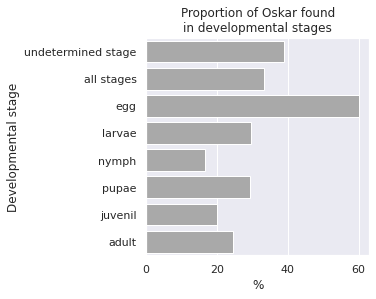

In [52]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=stage_df[stage_df['oskar'] == 'found'], x='count_proportion', y='simple_stage', order=stage_order, color='darkgray')

plt.xlabel('%')
plt.ylabel('Developmental stage')
plt.title('Proportion of Oskar found\nin developmental stages')


fig.savefig('../Figures/RAW/SVG/Oskar_Stage_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Oskar_Stage_distribution.pdf', format='pdf')

### 2. Plots for tissue types

In [61]:
tsa_raw_metadata[tsa_raw_metadata['clean_tissue'] == 'None']

,TSA,tsa_id,tax_id,species,family_id,family_name,order_id,order_name,bioproject,biosample,...,clean_tissue,clean_sex,clean_stage,brain,germline,egg,larvae,pupae,juvenil,adult
763,IADH,IADH00000000.1,85585,Adoxophyes honmai,7139.0,Tortricidae,7088,Lepidoptera,PRJDB6525,SAMD00128865,...,None,None,larvae,0,0,0,1,0,0,0
764,IADH,IADH00000000.1,85585,Adoxophyes honmai,7139.0,Tortricidae,7088,Lepidoptera,PRJDB6525,SAMD00128866,...,None,None,larvae,0,0,0,1,0,0,0
765,IADH,IADH00000000.1,85585,Adoxophyes honmai,7139.0,Tortricidae,7088,Lepidoptera,PRJDB6525,SAMD00128867,...,None,None,larvae,0,0,0,1,0,0,0
766,IADH,IADH00000000.1,85585,Adoxophyes honmai,7139.0,Tortricidae,7088,Lepidoptera,PRJDB6525,SAMD00128868,...,None,None,larvae,0,0,0,1,0,0,0
767,IADH,IADH00000000.1,85585,Adoxophyes honmai,7139.0,Tortricidae,7088,Lepidoptera,PRJDB6525,SAMD00128869,...,None,None,larvae,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,GAMM,GAMM00000000.1,48709,Orchesella cincta,48704.0,Entomobryidae,30001,Collembola,PRJNA211851,SAMN02231604,...,None,None,None,0,0,0,0,0,0,0
1037,GAMN,GAMN00000000.1,158441,Folsomia candida,36141.0,Isotomidae,30001,Collembola,PRJNA211850,SAMN01797285,...,None,female,None,0,0,0,0,0,0,0
1038,GASX,GASX00000000.2,158441,Folsomia candida,36141.0,Isotomidae,30001,Collembola,PRJNA219557,SAMN02047120,...,None,None,None,0,0,0,0,0,0,0
1039,GAXI,GAXI00000000.2,48717,Tetrodontophora bielanensis,48715.0,Onychiuridae,30001,Collembola,PRJNA219607,SAMN02047160,...,None,None,None,0,0,0,0,0,0,0


In [53]:
np.unique(tsa_raw_metadata['clean_tissue'])

array(['None', 'abdomen', 'abdominal tips', 'accessory gland',
       'accessory glands', 'antennae', 'blood', 'brain', 'bursa', 'egg',
       'egg & larvae', 'fat body', 'fat body & ovaries',
       'fat body & reproductive tissues', 'foregut', 'foreleg',
       'forelegs', 'gut', 'head', 'head & abdomen', 'head & antennae',
       'head & legs & thorax', 'head & prothorax', 'head & thorax',
       'hindleg', 'hindlegs', 'integument', 'large globular cells', 'leg',
       'legs', 'light organ', 'malpighian tubules', 'maxillary palps',
       'midgut', 'midleg', 'midlegs', 'mouthpart', 'muscle', 'ovaries',
       'pheromone gland', 'proboscises', 'prothoracic gland', 'prothorax',
       'reproductive organs', 'rostrums', 'salivary glands',
       'silk glands', 'spermatheca', 'spiral gland', 'tarsus', 'testes',
       'thoracic gland', 'thorax', 'undetermined tissue',
       'venom apparatus', 'venom gland', 'venom gland & venom sac',
       'whole organism', 'wing'], dtype=object)

In [54]:
print("Percent of TSA dataset with tissue metadata")
len(tsa_raw_metadata[~tsa_raw_metadata['clean_tissue'].isin(['None', 'undetermined tissue'])]['tsa_id'].unique()) / len(TSA_search_results)

Percent of TSA dataset with tissue metadata


0.7453250222617988

In [55]:
tissue_df = master_tsa_table.groupby(['clean_tissue', 'oskar'], as_index=False).count()[['clean_tissue', 'oskar', 'species']]
tissue_df = tissue_df.rename(columns={'species':'counts'})
total_tissue_df = master_tsa_table.groupby(['clean_tissue'], as_index=False).count()[['clean_tissue', 'species']]
tmp = tissue_df.merge(total_tissue_df, on='clean_tissue')
tissue_df['count_proportion'] = tmp['counts']/tmp['species'] * 100
total_tissue_df['overal_proportion'] = total_tissue_df['species']/total_tissue_df['species'].sum() * 100

In [56]:
tissue_df[tissue_df['oskar'] == 'found']
tissue_order = total_tissue_df.sort_values('overal_proportion')['clean_tissue'].values

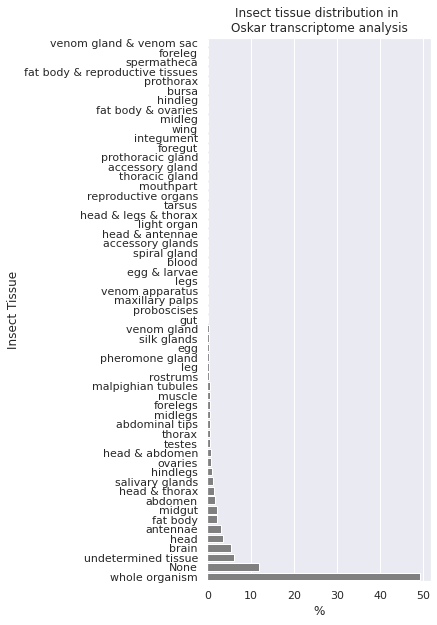

In [57]:
fig = plt.figure(figsize=(4,10))
sns.barplot(data=total_tissue_df, x='overal_proportion', y='clean_tissue', order=tissue_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Insect Tissue')
plt.title('Insect tissue distribution in \nOskar transcriptome analysis')


fig.savefig('../Figures/RAW/SVG/Tissue_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Tissue_distribution.pdf', format='pdf')

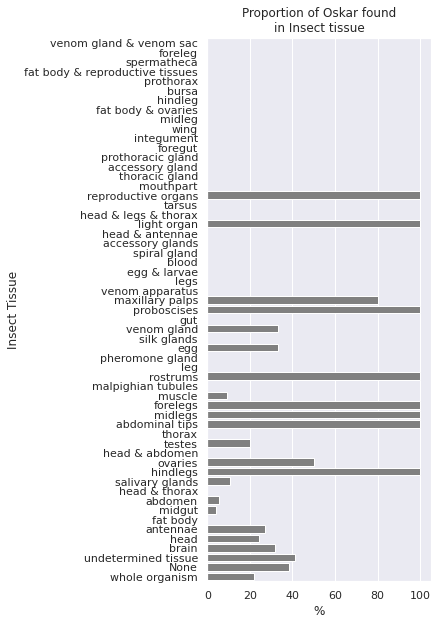

In [58]:
fig = plt.figure(figsize=(4,10))
sns.barplot(data=tissue_df[tissue_df['oskar'] == 'found'], x='count_proportion', y='clean_tissue', order=tissue_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Insect Tissue')
plt.title('Proportion of Oskar found\nin Insect tissue')


fig.savefig('../Figures/RAW/SVG/Oskar_Tissue_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Oskar_Tissue_distribution.pdf', format='pdf')

In [59]:
tissue_df

,clean_tissue,oskar,counts,count_proportion
0,None,found,102,38.490566
1,None,not found,163,61.509434
2,abdomen,found,2,5.405405
3,abdomen,not found,35,94.594595
4,abdominal tips,found,13,100.000000
...,...,...,...,...
67,venom gland,not found,4,66.666667
68,venom gland & venom sac,not found,1,100.000000
69,whole organism,found,241,22.009132
70,whole organism,not found,854,77.990868
